# NLP - Vector Space Semantics for Similarity between Friends Characters

In [1]:
!pip install nltk
!pip install contractions

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jovyan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
import string
import re
import numpy as np
from numpy.linalg import norm
import pandas as pd
from collections import Counter, OrderedDict

import seaborn as sns
import matplotlib.pyplot as plt

import math

from nltk.corpus import stopwords
from sklearn.impute import SimpleImputer
from nltk.stem import PorterStemmer, WordNetLemmatizer
from bs4 import BeautifulSoup
import contractions


from sklearn.feature_extraction import DictVectorizer

%matplotlib inline
pd.options.display.max_colwidth=500

In [4]:
# Load in training data and display in pandas dataframe
train_path='training.csv'
train_data = pd.read_csv(train_path,  delimiter="\t", skip_blank_lines = True)
val_path ='val.csv'
val_data = pd.read_csv(val_path,  delimiter="\t", skip_blank_lines = True)
test_path ='test.csv'
test_data = pd.read_csv(test_path,  delimiter="\t", skip_blank_lines = True)

# Inspect
train_data

,Episode,Scene,Character_name,Line,Gender
0,s01e01,c01,Monica Geller,There's nothing to tell! He's just some guy I work with!,Female
1,s01e01,c01,Joey Tribbiani,"C'mon, you're going out with the guy! There's gotta be something wrong with him!",Male
2,s01e01,c01,Chandler Bing,"All right Joey, be nice. So does he have a hump? A hump and a hairpiece?",Male
3,s01e01,c01,Phoebe Buffay,"Wait, does he eat chalk?",Female
4,s01e01,c01,Phoebe Buffay,"Just, 'cause, I don't want her to go through what I went through with Carl- oh!",Female
...,...,...,...,...,...
53548,s03e25,c12,Ross Geller,Hi.,Male
53549,s03e25,c13,Chandler Bing,Hi there.,Male
53550,s03e25,c13,Monica Geller,That's that weird voice again.,Female
53551,s03e25,c13,Chandler Bing,"Okay! Okay! Let me try it again, you're gonna wanna date this next guy, I swear!",Male


# Add dialogue context and scene features

In [5]:
def create_character_document_from_dataframe(df, max_line_count):
    """Returns a dict with the name of the character as key,
    their lines joined together as a single string, with end of line _EOL_
    markers between them. Incorporates dialogue context and scene features.

    ::max_line_count:: the maximum number of lines to be added per character
    """
    character_docs = {}
    character_line_count = {}

    # Group dataframe by Scene
    grouped_by_scene = df.groupby('Scene')

    for line, name, gender, scene in zip(df.Line, df.Character_name, df.Gender, df.Scene):
        # Remove empty lines
        if (isinstance(line, float) and math.isnan(line)) or line == "":
            continue

        # Initialize character_docs entry if not exists
        if name not in character_docs:
            character_docs[name] = ""
            character_line_count[name] = 0

        # Check if the line is from the same scene and add to the character's document
        if scene in grouped_by_scene.groups:
            scene_lines = grouped_by_scene.get_group(scene).Line.tolist()

            # Add lines before and after the target character's line as context
            context_lines = []
            line_index = scene_lines.index(line)

            # Add lines before the target character's line
            context_lines.extend(scene_lines[max(0, line_index - 2):line_index])

            # Add the target character's line
            context_lines.append(line)

            # Add lines after the target character's line
            context_lines.extend(scene_lines[line_index + 1:min(line_index + 3, len(scene_lines))])

            # Join context lines and add an end-of-line token
            character_docs[name] += " ".join(map(str, context_lines)) + " _EOL_ "
            character_line_count[name] += 1

        # Check if the maximum line count is reached for the character
        if character_line_count[name] == max_line_count:
            continue

    print("lines per character", character_line_count)
    return character_docs

In [6]:
# print out the number of words each character has in the training set
# only use the first 300 lines of each character
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ',len(train_character_docs.keys()),"\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ',len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

lines per character {'Monica Geller': 7538, 'Joey Tribbiani': 7141, 'Chandler Bing': 7607, 'Phoebe Buffay': 6550, '#ALL#': 318, 'Ross Geller': 7884, 'Rachel Green': 8063, 'Other_None': 4372, 'Other_Female': 1722, 'Other_Male': 2329}
Num. Characters:  10 

Monica Geller Number of Words:  388514
Joey Tribbiani Number of Words:  367577
Chandler Bing Number of Words:  397959
Phoebe Buffay Number of Words:  343496
#ALL# Number of Words:  13321
Ross Geller Number of Words:  406144
Rachel Green Number of Words:  419955
Other_None Number of Words:  215059
Other_Female Number of Words:  89132
Other_Male Number of Words:  118953
total words 2760110


# Improve pre-processing

In [7]:
train_data['Line'].fillna("", inplace=True)

def pre_process(character_text):
    """Enhanced pre-processing for character text.

    ::character_text:: a string with all of one character's lines
    """
    # Converting text into lowercase
    character_text = character_text.lower()

    # Expanding contractions
    character_text = contractions.fix(character_text)

    # Remove special characters, symbols and numbers from the text
    character_text = re.sub(r'[^a-zA-Z\s]', '', character_text)

    # Remove short words (length < 3)
    character_text = ' '.join([word for word in character_text.split() if len(word) > 2])

    # Remove single characters
    character_text = ' '.join([word for word in character_text.split() if len(word) > 1])

    # Tokenization
    tokens = nltk.word_tokenize(character_text)

    # Removeing stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.lower() not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]

    return tokens

In [8]:
# create list of pairs of (character name, pre-processed character)
training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

# Improve linguistic feature extraction

In [9]:
# Using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from nltk.sentiment import SentimentIntensityAnalyzer

def to_feature_vector_dictionary(character_doc, extra_features):
    """Enhanced feature extraction for a list of pre-processed tokens and extra features.

    ::character_doc:: a list of pre-processed tokens
    ::extra_features:: any extra features for the character to be added to the feature vector dict
    """
    # Word frequency count
    counts = Counter(character_doc)

    # Adding the extra features
    for feature in extra_features:
        if feature == 'ngrams':
            # Including n-grams of different lengths
            ngrams = Counter(nltk.ngrams(character_doc, 2))  # Change 2 to other values for different n-grams
            counts.update(ngrams)

        elif feature == 'pos_tags':
            # Including POS tags
            pos_tags = nltk.pos_tag(character_doc)
            pos_counts = Counter(tag for word, tag in pos_tags)
            counts.update(pos_counts)

        elif feature == 'tfidf':
            # Including TF-IDF scores
            tfidf_vectorizer = TfidfVectorizer()
            tfidf_matrix = tfidf_vectorizer.fit_transform([' '.join(character_doc)])
            tfidf_scores = {word: score for word, score in zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0])}
            counts.update(tfidf_scores)

        elif feature == 'sentiment':
            # Including sentiment analysis score
            sentiment_analyzer = SentimentIntensityAnalyzer()
            sentiment_score = sentiment_analyzer.polarity_scores(' '.join(character_doc))['compound']
            counts['sentiment'] = sentiment_score


    return counts

corpusVectorizer = DictVectorizer()

def create_document_matrix_from_corpus(corpus, fitting=False):
    """Enhanced method for fitting different vectorizers on data and returning a matrix.

    ::corpus:: a list of (class_label, document) pairs.
    ::fitting:: a boolean indicating whether to fit/train the vectorizers (should be true on training data)
    """
    if fitting:
        # Using TF-IDF vectorizer
        corpusVectorizer.fit([to_feature_vector_dictionary(doc, []) for name, doc in corpus])
    doc_feature_matrix = corpusVectorizer.transform([to_feature_vector_dictionary(doc, []) for name, doc in corpus])


    return doc_feature_matrix

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

In [10]:
training_feature_matrix

<10x12397 sparse matrix of type '<class 'numpy.float64'>'
	with 60608 stored elements in Compressed Sparse Row format>

In [11]:
# get the validation data- only 30 lines used for each character
val_character_docs = create_character_document_from_dataframe(val_data, max_line_count=30)
print('Num. Characters: ',len(val_character_docs.keys()),"\n")
total_words = 0
for name in val_character_docs.keys():
    print(name, 'Num of Words: ',len(val_character_docs[name].split()))
    total_words += len(val_character_docs[name].split())
print("total words", total_words)

# create list of pairs of (character name, pre-processed character)
val_corpus = [(name, pre_process(doc)) for name, doc in sorted(val_character_docs.items())]
val_labels = [name for name, doc in val_corpus]

lines per character {'Other_None': 275, 'Rachel Green': 589, 'Other_Male': 171, 'Ross Geller': 571, '#ALL#': 18, 'Phoebe Buffay': 504, 'Chandler Bing': 591, 'Monica Geller': 525, 'Joey Tribbiani': 627, 'Other_Female': 87}
Num. Characters:  10 

Other_None Num of Words:  14025
Rachel Green Num of Words:  31285
Other_Male Num of Words:  8910
Ross Geller Num of Words:  30172
#ALL# Num of Words:  802
Phoebe Buffay Num of Words:  27510
Chandler Bing Num of Words:  32264
Monica Geller Num of Words:  26985
Joey Tribbiani Num of Words:  34092
Other_Female Num of Words:  4617
total words 210662


In [12]:
# Transforming the val_feature_matrix, don't fit
val_feature_matrix = create_document_matrix_from_corpus(val_corpus, fitting=False)

In [13]:
val_feature_matrix

<10x12397 sparse matrix of type '<class 'numpy.float64'>'
	with 11552 stored elements in Compressed Sparse Row format>

In [14]:
def compute_cosine_similarity(v1, v2):
    """Takes a pair of vectors v1 and v2 (1-d arrays e.g. [0, 0.5, 0.5])
    returns the cosine similarity between the vectors
    """

    # compute cosine similarity manually
    manual_cosine_similarity = np.dot(v1, v2)  /(norm(v1) * norm(v2))

    return manual_cosine_similarity

In [15]:
def compute_IR_evaluation_scores(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    """
    Computes an information retrieval based on training data feature matrix and test data feature matrix
    returns 4-tuple:
    ::mean_rank:: mean of the ranking of the target document in terms of similarity to the query/test document
    1 is the best possible score.
    ::mean_cosine_similarity:: mean cosine similarity score for the target document vs. the test document of the same class
    ::accuracy:: proportion of test documents correctly classified
    ::df:: a data frame with all the similarity measures of the test documents vs. train documents

    params:
    ::train_feature_matrix:: a numpy matrix N x M shape where N = number of characters M = number of features
    ::test_feature_matrix::  a numpy matrix N x M shape where N = number of characters M = number of features
    ::train_labels:: a list of character names for the training data in order consistent with train_feature_matrix
    ::test_labels:: a list of character names for the test data in order consistent with test_feature_matrix
    """
    rankings = []
    all_cosine_similarities = []
    pairwise_cosine_similarity = []
    pairs = []
    correct = 0
    for i, target in enumerate(test_labels):
        # compare the left out character against the mean
        idx = i
        fm_1 = test_feature_matrix.toarray()[idx]
        all_sims = {}
        # print("target:", target)
        for j, other in enumerate(train_labels):
            fm_2 = train_feature_matrix.toarray()[j]
            manual_cosine_similarity = compute_cosine_similarity(fm_1, fm_2)
            pairs.append((target, other))
            pairwise_cosine_similarity.append(manual_cosine_similarity)
            if other == target:
                all_cosine_similarities.append(manual_cosine_similarity)
            all_sims[other] = manual_cosine_similarity

            # print(target, other, manual_cosine_similarity)
        sorted_similarities = sorted(all_sims.items(),key=lambda x:x[1],reverse=True)
        # print(sorted_similarities)
        ranking = {key[0]: rank for rank, key in enumerate(sorted_similarities, 1)}
        # print("Ranking for target", ranking[target])
        if ranking[target] == 1:
            correct += 1
        rankings.append(ranking[target])

    mean_rank = np.mean(rankings)
    mean_cosine_similarity = np.mean(all_cosine_similarities)
    accuracy = correct/len(test_labels)
    print("mean rank", np.mean(rankings))
    print("mean cosine similarity", mean_cosine_similarity)
    print(correct, "correct out of", len(test_labels), "/ accuracy:", accuracy )

    # get a dafaframe showing all the similarity scores of training vs test docs
    df = pd.DataFrame({'doc1': [x[0] for x in pairs], 'doc2': [x[1] for x in pairs],
                       'similarity': pairwise_cosine_similarity})

    # display characters which are most similar and least similar
    df.loc[[df.similarity.values.argmax(), df.similarity.values.argmin()]]
    return (mean_rank, mean_cosine_similarity, accuracy, df)

# Parameter Search                                                            

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer

# Example grid search for TF-IDF vectorizer
param_grid_tfidf = {
    'tfidf__max_features': [500, 1000, 2000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

tfidf_vectorizer = TfidfVectorizer()
pipeline_tfidf = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('ch2', SelectKBest(chi2)),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

grid_search_tfidf = GridSearchCV(pipeline_tfidf, param_grid=param_grid_tfidf, scoring='accuracy', cv=5)
grid_search_tfidf.fit(train_data['Line'], train_data['Character_name'])
best_tfidf_params = grid_search_tfidf.best_params_

# Use best parameters in the final model
tfidf_vectorizer = TfidfVectorizer(max_features=best_tfidf_params['tfidf__max_features'], ngram_range=best_tfidf_params['tfidf__ngram_range'])

# Creating a new pipeline with the classifier
final_pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('ch2', SelectKBest(chi2)), # feature selection using k best
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))  # Use Random Forest as an example
])

# Training the final model on the entire training set
final_pipeline.fit(train_data['Line'], train_data['Character_name'])

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=500, ngram_range=(1, 2))),
                ('ch2',
                 SelectKBest(score_func=<function chi2 at 0x7f7e45400e50>)),
                ('classifier', RandomForestClassifier(random_state=42))])

In [17]:
def plot_heat_map_similarity(df):
    """Takes a dataframe with header 'doc1, doc2, similarity'
    Plots a heatmap based on the similarity scores.
    """
    test_labels =  sorted(list(set(df.sort_values(['doc1'])['doc1'])))
    # add padding 1.0 values to either side
    cm = [[1.0,] * (len(test_labels)+2)]
    for target in test_labels:
        new_row = [1.0]
        for x in df.sort_values(['doc1', 'doc2'])[df['doc1']==target]['similarity']:
            new_row.append(x)
        new_row.append(1.0)
        cm.append(new_row)
    cm.append([1.0,] * (len(test_labels)+2))
    #print(cm)
    labels = [""] + test_labels + [""]
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Similarity matrix between documents as vectors')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):

            text = ax.text(j, i, round(cm[i][j],3),
                           ha="center", va="center", color="w")

    plt.xlabel('Training Vector Doc')
    plt.ylabel('Test Vector Doc')
    #fig.tight_layout()
    plt.show()

# Analyse the similarity results

mean rank 2.0
mean cosine similarity 0.9448064943880624
8 correct out of 10 / accuracy: 0.8
Closest Vectors:
[('#ALL#', 'Joey Tribbiani'), ('Chandler Bing', 'Monica Geller'), ('Joey Tribbiani', 'Chandler Bing'), ('Monica Geller', 'Chandler Bing'), ('Other_Female', 'Other_None'), ('Other_Male', 'Monica Geller'), ('Other_None', 'Other_Male'), ('Phoebe Buffay', 'Rachel Green'), ('Rachel Green', 'Ross Geller'), ('Ross Geller', 'Rachel Green')]

Furthest Vectors:
[('#ALL#', 'Other_Male'), ('Chandler Bing', '#ALL#'), ('Joey Tribbiani', '#ALL#'), ('Monica Geller', '#ALL#'), ('Other_Female', '#ALL#'), ('Other_Male', '#ALL#'), ('Other_None', '#ALL#'), ('Phoebe Buffay', '#ALL#'), ('Rachel Green', '#ALL#'), ('Ross Geller', '#ALL#')]


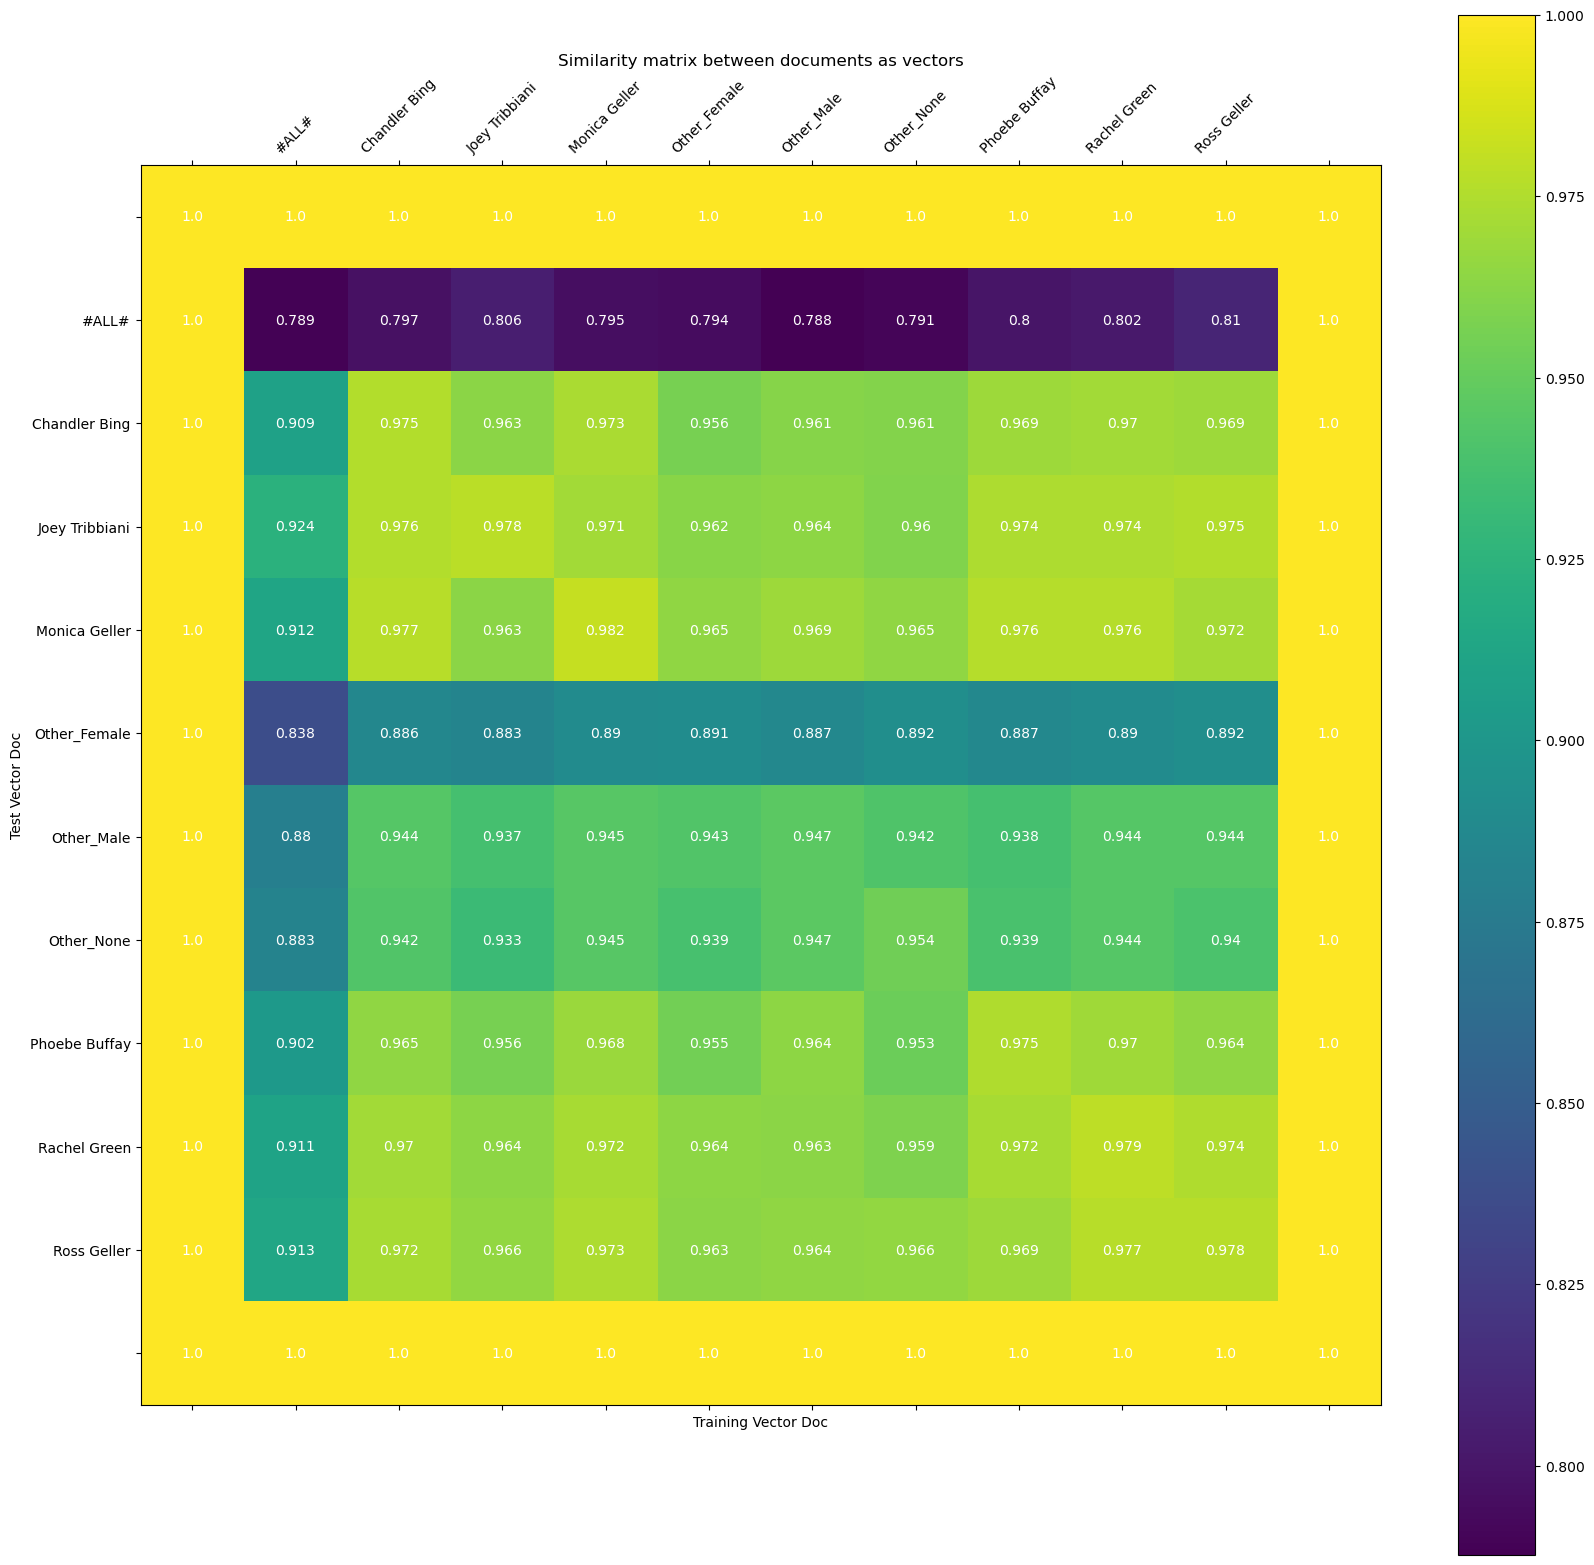

In [18]:
# Define a function to find closest and furthest vectors for each training character
def find_closest_and_furthest_vectors(train_feature_matrix, test_feature_matrix, train_labels, test_labels):
    closest_vectors = []
    furthest_vectors = []

    # Rank heldout vectors based on similarity for each training character
    for train_char in train_labels:
        char_df = df[df['doc1'] == train_char]
        ranked_df = char_df.sort_values(by='similarity', ascending=False)

        # Extract closest and furthest vectors
        closest_vector = ranked_df.iloc[1]['doc2']  # Skip the first row as it's the same character
        furthest_vector = ranked_df.iloc[-1]['doc2']

        closest_vectors.append((train_char, closest_vector))
        furthest_vectors.append((train_char, furthest_vector))

    return closest_vectors, furthest_vectors

# Step 1: Compute IR evaluation scores
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

# Step 2: Find closest and furthest vectors
closest_vectors, furthest_vectors = find_closest_and_furthest_vectors(training_feature_matrix, val_feature_matrix, train_labels, val_labels)

# Step 3: Print closest and furthest vectors
print("Closest Vectors:")
print(closest_vectors)
print("\nFurthest Vectors:")
print(furthest_vectors)

# Step 4: Plot heatmap
plot_heat_map_similarity(df)

# Run on final test data

In [19]:
# Redo on training data with the first 300 character lines used
train_character_docs = create_character_document_from_dataframe(train_data, max_line_count=300)
print('Num. Characters: ', len(train_character_docs.keys()), "\n")
total_words = 0
for name in train_character_docs.keys():
    print(name, 'Number of Words: ', len(train_character_docs[name].split()))
    total_words += len(train_character_docs[name].split())
print("total words", total_words)

training_corpus = [(name, pre_process(doc)) for name, doc in sorted(train_character_docs.items())]
train_labels = [name for name, doc in training_corpus]

training_feature_matrix = create_document_matrix_from_corpus(training_corpus, fitting=True)

# Get the test data using 30 lines per character
test_character_docs = create_character_document_from_dataframe(test_data, max_line_count=30)
print('Num. Characters: ', len(test_character_docs.keys()), "\n")
total_words = 0
for name in test_character_docs.keys():
    print(name, 'Number of Words: ', len(test_character_docs[name].split()))
    total_words += len(test_character_docs[name].split())
print("total words", total_words)

# Create a list of pairs of (character name, pre-processed character)
test_corpus = [(name, pre_process(doc)) for name, doc in sorted(test_character_docs.items())]
test_labels = [name for name, doc in test_corpus]

# Using the same vectorizer and other transformers as in training
# Only transforming the test data
test_feature_matrix = create_document_matrix_from_corpus(test_corpus, fitting=False)

# Evaluate on the test data
mean_rank, mean_cosine_similarity, acc, df = compute_IR_evaluation_scores(training_feature_matrix, test_feature_matrix, train_labels, test_labels)
print("Test Mean Rank:", mean_rank)
print("Test Mean Cosine Similarity:", mean_cosine_similarity)
print("Test Accuracy:", acc)

lines per character {'Monica Geller': 7538, 'Joey Tribbiani': 7141, 'Chandler Bing': 7607, 'Phoebe Buffay': 6550, '#ALL#': 318, 'Ross Geller': 7884, 'Rachel Green': 8063, 'Other_None': 4372, 'Other_Female': 1722, 'Other_Male': 2329}
Num. Characters:  10 

Monica Geller Number of Words:  388506
Joey Tribbiani Number of Words:  367563
Chandler Bing Number of Words:  397951
Phoebe Buffay Number of Words:  343468
#ALL# Number of Words:  13321
Ross Geller Number of Words:  406133
Rachel Green Number of Words:  419937
Other_None Number of Words:  215052
Other_Female Number of Words:  89128
Other_Male Number of Words:  118949
total words 2760008
lines per character {'Ross Geller': 705, 'Joey Tribbiani': 440, 'Chandler Bing': 370, 'Other_Female': 190, 'Other_None': 317, '#ALL#': 11, 'Monica Geller': 434, 'Rachel Green': 676, 'Phoebe Buffay': 482, 'Other_Male': 201}
Num. Characters:  10 

Ross Geller Number of Words:  35746
Joey Tribbiani Number of Words:  23803
Chandler Bing Number of Words:  